In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import cv2
import copy, random, os, subprocess
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models, preprocessing
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()    

/opt/conda/lib/python3.7/site-packages/flatbuffers/compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:23: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:24: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:25: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:28: Depreca

In [2]:
MODEL_NAME = 'model04'
BUCKET = 'gs://etsuji-car-racing-v2'
os.environ['BUCKET'] = BUCKET
!gsutil ls $BUCKET

gs://etsuji-car-racing-v2/model04/


In [3]:
class QValue:
    def __init__(self):
        self.model = None

    def get_action(self, state):
        states = []
        actions = []
        for a in range(5):
            states.append(np.array(state))
            action_onehot = np.zeros(5)
            action_onehot[a] = 1
            actions.append(action_onehot)
  
        q_values = self.model.predict([np.array(states), np.array(actions)])
        optimal_action = np.argmax(q_values)
        return optimal_action, q_values[optimal_action][0]

In [4]:
def join_frames(o0, o1):
    return np.r_[o0.transpose(), o1.transpose()].transpose() 

In [5]:
def get_target_image(q_value, start, end, num):
    step = (end - start) // num
    env = gym.make("CarRacing-v2", continuous=False)
    o0 = env.reset()
    o1 = copy.deepcopy(o0)
    done = 0
    total_r = 0
    target_images = []

    for c in range(end):
        if c >= start and c % step == 0:
            target_images.append([o0, o1])
        a, _ = q_value.get_action(join_frames(o0, o1))
        o_new, r, done, i = env.step(a)
        if done:
            print('Game ended at step={}'.format(c))
            return None
        total_r += r
        o0, o1 = o1, o_new
        
    return target_images

In [6]:
def get_grads(q_value, target_image):
    o0, o1 = target_image
    target_image = join_frames(o0, o1)
    a, _ = q_value.get_action(target_image)
    action_onehot = np.zeros(5)
    action_onehot[a] = 1
    
    model = q_value.model
    pred_output = model.output # Q Value for a specific action
    last_conv_layer = model.get_layer('cnn2')

    grads = K.gradients(pred_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    get_vals = K.function([model.input],
                          [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_val, conv_layer_output_val = get_vals([np.array([target_image]),
                                                        np.array([action_onehot])])
    fig = plt.figure(figsize=(20, 12))
    for i in range(last_conv_layer.output.shape[-1]):
        subplot = fig.add_subplot(8, 16, i+1)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(conv_layer_output_val[:, :, i], cmap=plt.cm.gray_r)
        subplot.title.set_text('{:0.3f}'.format(pooled_grads_val[i]))

In [14]:
def get_heatmap(q_value, target_image):
    o0, o1 = target_image
    target_image = join_frames(o0, o1)
    a, _ = q_value.get_action(target_image)
    action_onehot = np.zeros(5)
    action_onehot[a] = 1
    
    model = q_value.model
    pred_output = model.output # Q Value for a specific action
    last_conv_layer = model.get_layer('cnn2')

    grads = K.gradients(pred_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    get_vals = K.function([model.input],
                          [pooled_grads, last_conv_layer.output[0]])

    pooled_grads_val, conv_layer_output_val = get_vals([np.array([target_image]),
                                                        np.array([action_onehot])])
    heatmap = np.zeros([96 // 2, 96 // 2])
    for i in range(last_conv_layer.output.shape[-1]):
        if pooled_grads_val[i] > 0:
            heatmap += conv_layer_output_val[:, :, i] * pooled_grads_val[i]
    h_mean = heatmap.mean()
    h_std  = np.std(heatmap)
    heatmap = (heatmap - h_mean) / h_std
    heatmap = np.clip(heatmap, a_min=-1, a_max=1)
    heatmap = (heatmap + 1) / 2

    heatmap = np.uint8(255 * cv2.resize(heatmap, (96, 96)))
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_BONE)
    superimposed_img = heatmap * 0.35 + cv2.cvtColor(o0, cv2.COLOR_RGB2BGR) * 0.65
    
    cv2.imwrite('/tmp/result.jpg', superimposed_img)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = preprocessing.image.load_img('/tmp/result.jpg')

    return o0, heatmap, superimposed_img    

In [8]:
def load_model(q_value, checkpoint, model='model01'):
    BUCKET = 'gs://etsuji-car-racing-v2'
    filename = 'car-racing-v2-{}-{}.hd5'.format(checkpoint, model)
    if not os.path.isfile(filename):
        subprocess.run(['gsutil', 'cp', '{}/{}/{}'.format(BUCKET, model, filename), './'])
    
    print('load model {}'.format(filename))
    q_value.model = models.load_model(filename)

In [9]:
q_value = QValue()
load_model(q_value, 741, 'model04')

load model car-racing-v2-741-model04.hd5


2022-07-29 08:08:08.533374: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 08:08:08.545142: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 08:08:08.545833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 08:08:08.547713: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [53]:
target_images = get_target_image(q_value, 50, 800, 40)

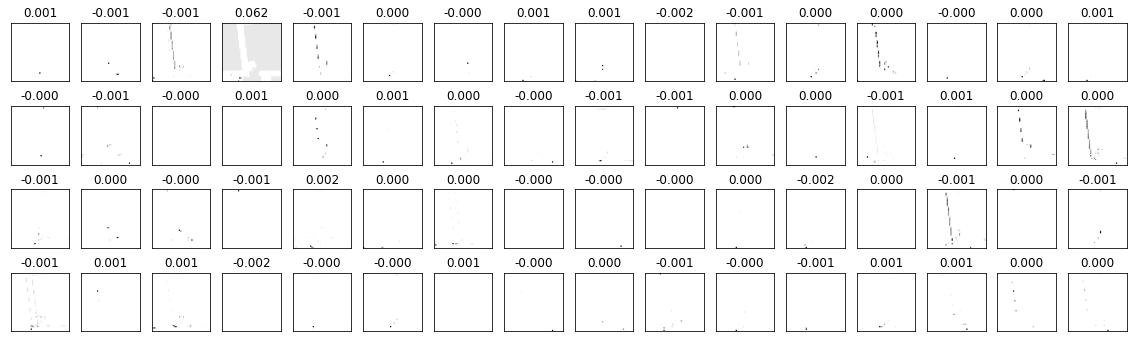

In [54]:
get_grads(q_value, target_images[5])

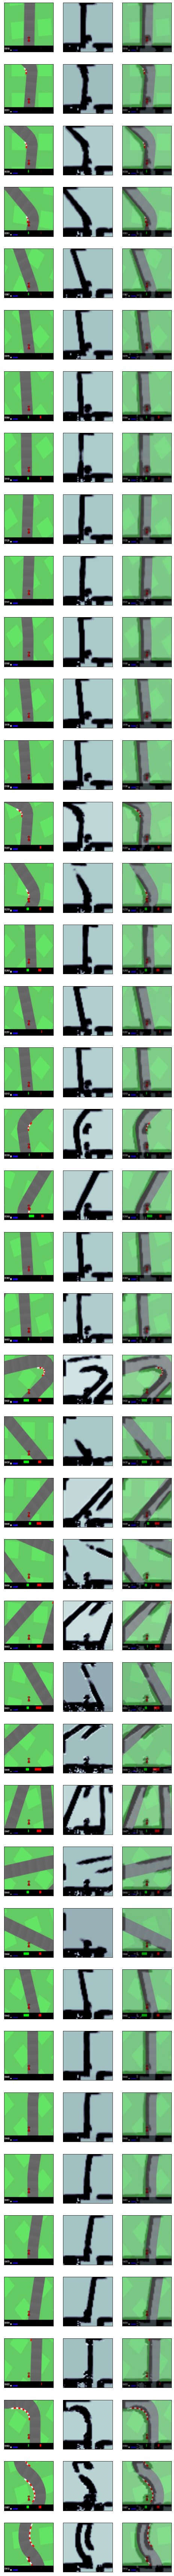

In [55]:
num = len(target_images)
fig = plt.figure(figsize=(8, num * 3))
c = 1
for i in range(len(target_images)):
    original, heatmap, superimposed = get_heatmap(q_value, target_images[i])
    #print(heatmap.shape)
    subplot = fig.add_subplot(num, 3, c)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(original)
    c += 1
    subplot = fig.add_subplot(num, 3, c)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(heatmap)
    c += 1
    subplot = fig.add_subplot(num, 3, c)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(superimposed)
    c += 1